In [1]:
using LinearAlgebra
using Zygote
using Printf
using Plots
using JLD2

include("cMPO.jl")
using .cMPO

bondD = 15
beta = 20.0
model1 = cMPO.cmpoaction.XXZModel(1.0, 1.0)

T = model1.T
W = model1.W
d = model1.d
ph_leg = model1.ph_leg

psi = cMPO.cmpoaction.cmps(T.Q, T.L)
Lpsi = cMPO.cmpoaction.cmps(T.Q, T.R)

init_step = Int(floor(log(bondD) / log(ph_leg)))
for ix in 1:init_step - 1
    psi = cMPO.cmpoaction.act(T, psi)
    Lpsi = cMPO.cmpoaction.act(cMPO.cmpoaction.transpose(T), psi)
end

power_counter = 0
step = 0
Fmin = 9.9e9
omega = 1.0
eta = 0.05
s = cMPO.cmpoaction.PauliSpin()

Main.cMPO.cmpoaction.PauliSpin([1.0 0.0; 0.0 1.0], [0.0 1.0; 1.0 0.0], ComplexF64[0.0 + 0.0im 0.0 - 1.0im; 0.0 + 1.0im 0.0 + 0.0im], [1.0 0.0; 0.0 -1.0], [0.0 1.0; 0.0 0.0], [0.0 0.0; 1.0 0.0])

In [2]:
while power_counter < 3
    if size(psi.Q, 1) <= bondD
        Tpsi = cMPO.cmpoaction.act(T, psi)
    else
        Tpsi = psi
    end
    
    # 微分优化
    psi = cMPO.cmpoaction.variational_compr(Tpsi, beta, bondD)
    Lpsi = cMPO.cmpoaction.multiply(W, psi)

    # 可观测量
    F_value = cMPO.cmpoaction.F(psi, Lpsi, T, beta)
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    chi_value = cMPO.cmpoaction.chi(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega) / beta
    chi2_value = cMPO.cmpoaction.chi2(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, eta)
    spectral_value = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, eta)

    # 打印输出
    @printf("%d %.12f %.12f %.12f %.12f %.12f\n", step, F_value, Cv_value, chi_value, chi2_value, spectral_value)

    step += 1
    
    # 连续三次达到优化阈值输出
    if F_value < Fmin - 1e-11
        power_counter = 0
        Fmin = F_value
    else
        power_counter += 1
    end
end

filename = @sprintf "1bondD_%d_beta_%.1f_omega_%.1f_eta_%.1f.jld2" bondD beta omega eta
@save filename psi Lpsi

Adaptive MERA Update

step        θ/π               ΔlnF                1.0 - F      
----  ----------------  -----------------   -------------------
001   1.0000000000e+00   9.8999999663e+09   1.0000000000e+00
002   2.4414062500e-04   9.8999999663e+09   1.0000000000e+00
003   2.4414062500e-04   0.0000000000e+00   1.0000000000e+00
 * Status: success

 * Candidate solution
    Final objective value:     -3.374991e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.17e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.25e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.63e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.82e-13 ≤ 2.2e-09
    |g(x)|                 = 2.86e-06 ≰ 1.0e-09

 * Work counters
    Seconds run:   307  (vs limit Inf)
    Iterations:    2
    f(x) calls:    6
    ∇f(x) calls:   6

0 -0.416814386219 0.376440784603 -0.006795565936 0.400774076215 0.801548154082
Adaptive MERA Update

step        θ/π               ΔlnF                1.

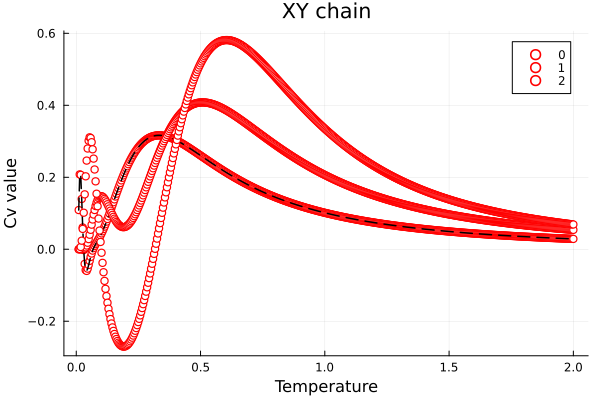

In [3]:
# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="0")
plot!(temperatures, Cv_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

# 导入参数
@load "1bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter!(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="1")

# 导入参数
@load "2bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter!(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="2")

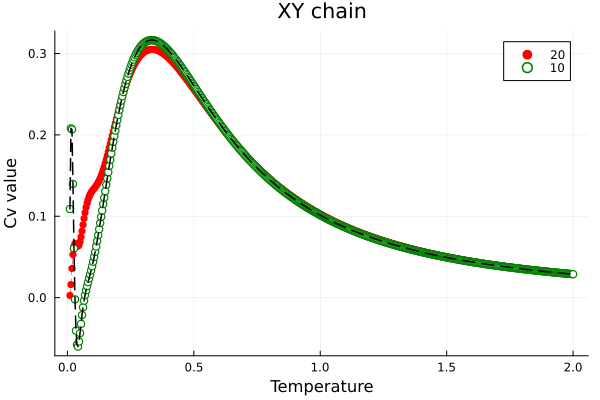

In [5]:
# 导入参数
@load "bondD_20_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:red, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="20")
plot!(temperatures, Cv_values, linecolor=:red, linestyle=:dash, linewidth=0.5, label=false)

# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter!(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:white, markershape=:circle, markerstrokecolor=:green, markerstrokewidth=1.5, markerfillcolor=:transparent, label="10")
plot!(temperatures, Cv_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)


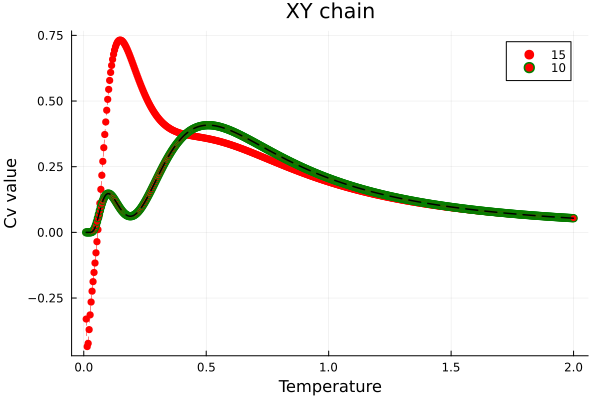

In [6]:
# 导入参数
@load "1bondD_15_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:red, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="15")
plot!(temperatures, Cv_values, linecolor=:red, linestyle=:dash, linewidth=0.5, label=false)

# 导入参数
@load "1bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制 Cv_value 随温度的变化
temperatures = range(0.01, stop=2.0, length=500)
Cv_values = []

for TT in temperatures
    beta = 1.0 / TT
    Cv_value = cMPO.cmpoaction.Cv(psi, Lpsi, T, beta)
    push!(Cv_values, Cv_value)
end

# 绘制图像
scatter!(temperatures, Cv_values, xlabel="Temperature", ylabel="Cv value", title="XY chain",
        markercolor=:red, markershape=:circle, markerstrokecolor=:green, markerstrokewidth=1.5, markerfillcolor=:transparent, label="10")
plot!(temperatures, Cv_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

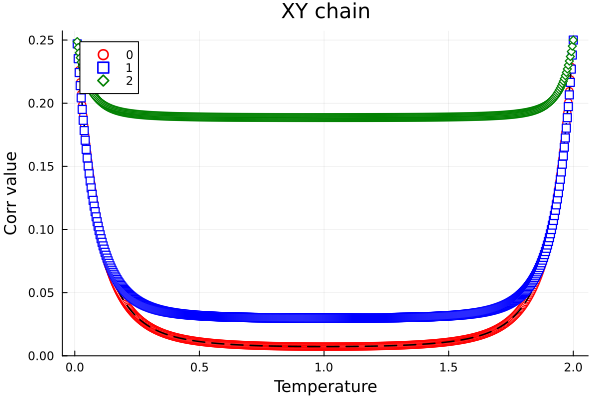

In [12]:
# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter(temperatures, Corr_values, xlabel="tau", ylabel="Corr value", title="correlation",
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="0")
plot!(temperatures, Corr_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

# 导入参数
@load "1bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter!(temperatures, Corr_values, xlabel="Temperature", ylabel="Corr value", title="XY chain",
        markercolor=:white, markershape=:rect, markerstrokecolor=:blue, markerstrokewidth=1.5, markerfillcolor=:transparent, label="1")

# 导入参数
@load "2bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter!(temperatures, Corr_values, xlabel="Temperature", ylabel="Corr value", title="XY chain",
        markercolor=:white, markershape=:diamond, markerstrokecolor=:green, markerstrokewidth=1.5, markerfillcolor=:transparent, label="2")

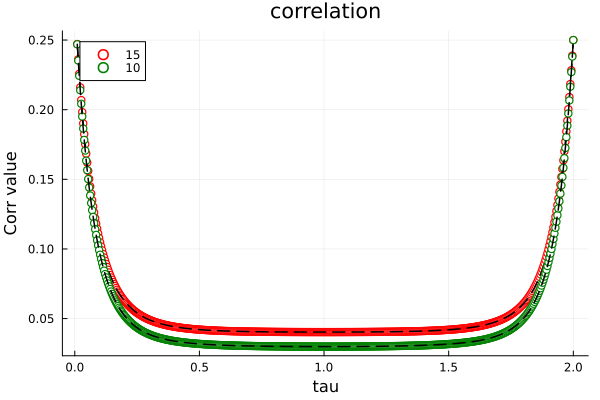

In [7]:
# 导入参数
@load "1bondD_15_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter(temperatures, Corr_values, xlabel="tau", ylabel="Corr value", title="correlation",
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="15")
plot!(temperatures, Corr_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

# 导入参数
@load "1bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter!(temperatures, Corr_values, xlabel="tau", ylabel="Corr value", title="correlation",
        markercolor=:white, markershape=:circle, markerstrokecolor=:green, markerstrokewidth=1.5, markerfillcolor=:transparent, label="10")
plot!(temperatures, Corr_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

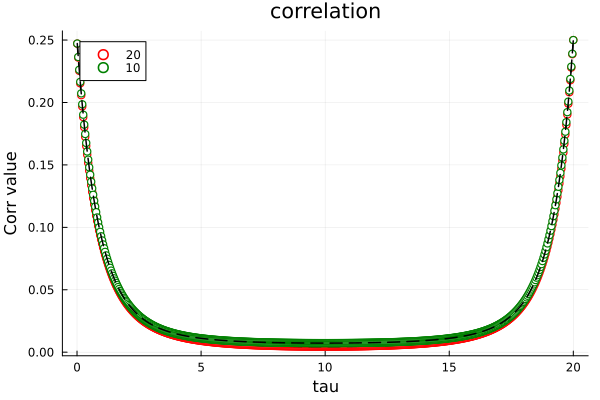

In [3]:
# 导入参数
@load "bondD_20_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter(Tau, Corr_values, xlabel="tau", ylabel="Corr value", title="correlation",
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="20")
plot!(Tau, Corr_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 计算并绘制
Tau = range(0.01, stop=20.0, length=500)
Corr_values = []

for tau in Tau
    Corr_value = cMPO.cmpoaction.Corr(psi, Lpsi, T, s.Z/2, s.Z/2, 20.0, tau)
    push!(Corr_values, Corr_value)
end

# 绘制图像
scatter!(Tau, Corr_values, xlabel="tau", ylabel="Corr value", title="correlation",
        markercolor=:white, markershape=:circle, markerstrokecolor=:green, markerstrokewidth=1.5, markerfillcolor=:transparent, label="10")
plot!(Tau, Corr_values, linecolor=:black, linestyle=:dash, linewidth=1.5, label=false)

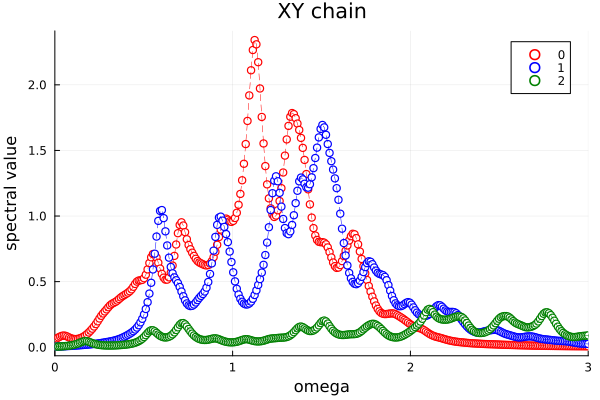

In [2]:
# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 优化结束后，计算并绘制图像
omegas = range(0, stop=3, length=300)
spectral_values_psi = []

for omega in omegas
    spectral_value_psi = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.05)
    push!(spectral_values_psi, spectral_value_psi)
end

# 绘制图像
scatter(omegas, spectral_values_psi,
        markercolor=:white, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="0", 
        xlabel="omega", ylabel="spectral value", title="XY chain")
plot!(omegas, spectral_values_psi, linecolor=:red, linestyle=:dash, linewidth=0.5, label=false)

# 导入参数
@load "1bondD_15_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 优化结束后，计算并绘制图像
spectral_values_psi = []

for omega in omegas
    spectral_value_psi = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.05)
    push!(spectral_values_psi, spectral_value_psi)
end

# 绘制图像
scatter!(omegas, spectral_values_psi,
         markercolor=:white, markershape=:circle, markerstrokecolor=:blue, markerstrokewidth=1.5, markerfillcolor=:transparent, label="1")
plot!(omegas, spectral_values_psi, linecolor=:blue, linestyle=:dash, linewidth=0.5, label=false)

# 导入参数
@load "2bondD_10_beta_20.0_omega_1.0_eta_0.1.jld2" psi Lpsi

# 优化结束后，计算并绘制图像
spectral_values_psi = []

for omega in omegas
    spectral_value_psi = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.05)
    push!(spectral_values_psi, spectral_value_psi)
end

# 绘制图像
scatter!(omegas, spectral_values_psi,
         markercolor=:white, markershape=:circle, markerstrokecolor=:green, markerstrokewidth=1.5, markerfillcolor=:transparent, label="2")
plot!(omegas, spectral_values_psi, linecolor=:green, linestyle=:dash, linewidth=0.5, label=false, xlim=(0, 3))


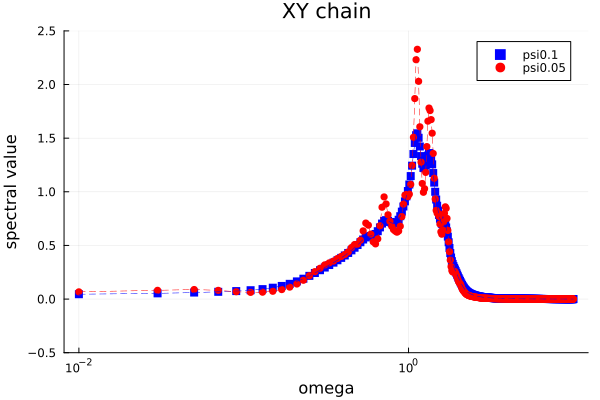

In [6]:
# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 优化结束后，计算并绘制图像
omegas = range(0.01, stop=10, length=500)
spectral_values_psi5 = []
spectral_values_psi1 = []

for omega in omegas
    spectral_value_psi5 = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.05)
    push!(spectral_values_psi5, spectral_value_psi5)
    
    spectral_value_psi1 = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.1)
    push!(spectral_values_psi1, spectral_value_psi1)
end

# 绘制图像
scatter(omegas, spectral_values_psi1, xscale=:log10, xlabel="omega", ylabel="spectral value", title="XY chain", 
        markercolor=:blue, markershape=:rect, markerstrokecolor=:blue, markerstrokewidth=1.5, markerfillcolor=:transparent, yrange=(-0.5, 2.5), label="psi0.1")
scatter!(omegas, spectral_values_psi5, xscale=:log10, 
         markercolor=:red, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="psi0.05")
plot!(omegas, spectral_values_psi1, linecolor=:blue, linestyle=:dash, linewidth=0.5, label=false)
plot!(omegas, spectral_values_psi5, linecolor=:red, linestyle=:dash, linewidth=0.5, label=false)

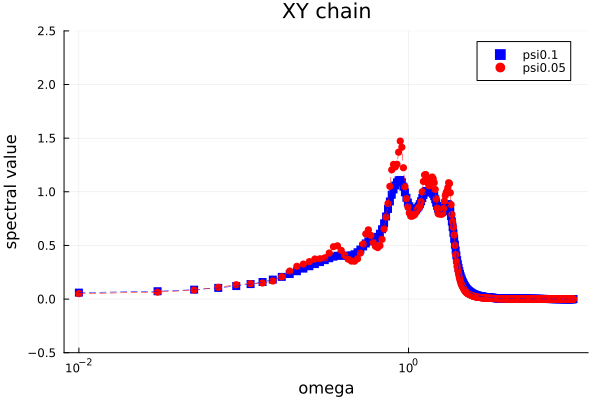

In [22]:
# 导入参数
@load "bondD_20_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

# 优化结束后，计算并绘制图像
omegas = range(0.01, stop=10, length=500)
spectral_values_psi5 = []
spectral_values_psi1 = []

for omega in omegas
    spectral_value_psi5 = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.05)
    push!(spectral_values_psi5, spectral_value_psi5)
    
    spectral_value_psi1 = cMPO.cmpoaction.spectral(psi, Lpsi, T, s.Z/2, s.Z/2, beta, omega, 0.1)
    push!(spectral_values_psi1, spectral_value_psi1)
end

# 绘制图像
scatter(omegas, spectral_values_psi1, xscale=:log10, xlabel="omega", ylabel="spectral value", title="XY chain", 
        markercolor=:blue, markershape=:rect, markerstrokecolor=:blue, markerstrokewidth=1.5, markerfillcolor=:transparent, yrange=(-0.5, 2.5), label="psi0.1")
scatter!(omegas, spectral_values_psi5, xscale=:log10, 
         markercolor=:red, markershape=:circle, markerstrokecolor=:red, markerstrokewidth=1.5, markerfillcolor=:transparent, label="psi0.05")
plot!(omegas, spectral_values_psi1, linecolor=:blue, linestyle=:dash, linewidth=0.5, label=false)
plot!(omegas, spectral_values_psi5, linecolor=:red, linestyle=:dash, linewidth=0.5, label=false)

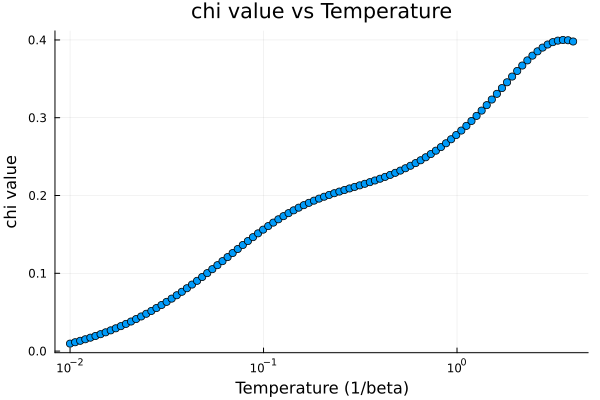

In [9]:
# 导入参数
@load "bondD_10_beta_20.0_omega_1.0_eta_0.05.jld2" psi Lpsi

beta_values = 10 .^ range(-2, stop=0.6, length=100)
chi_values = []

for beta in beta_values
    chi_value = cMPO.cmpoaction.chi(psi, Lpsi, T, s.Z/2, s.Z/2, beta, 1.0) / beta
    push!(chi_values, chi_value)
end

# 绘制图像
plot(beta_values, chi_values, xscale=:log10, xlabel="Temperature (1/beta)", ylabel="chi value", title="chi value vs Temperature", markershape=:circle, line=:dash, legend=false)